# Boundary Relation Tests

## Setup

### Imports

In [1]:
# Shared Packages
import pandas as pd

# Local functions and classes
from types_and_classes import *
from utilities import *
from debug_tools import *
from structure_slice import *
from metrics import *
from relations import *

### Global Settings

In [2]:
PRECISION = 2

In [3]:
%matplotlib inline

## Boundary Check process
1. Build slice table (index= slice, columns = ROI, Data= StructureSlice)
2. Select Primary & Secondary ROI
	- Slice range = Min(starting slice) to Max(ending slice)
3. Send all slices with both Primary and Secondary contours for standard relation testing 
4. Identify the boundary slices of the Primary and Secondary ROI
    - Boundary slices are slices that have a contour, but one of their neighbouring slices do not have a contour.
5. For each boundary slice of the Primary ROI identify the neighbouring slice(s) that do not have a primary.
6. For each of these neighbouring slices select a Secondary slice for boundary tests:
	- If the slice has a Secondary contour, select that Secondary slice.
	- If the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.
	- If neither the neighbouring slice nor the same slice as the Primary boundary have a Secondary contour, do not select a Secondary slice. Boundary testing is not required.
7. Test the relation between the boundary Primary and the selected Secondary.
8. Apply a Primary boundary shift to the relation results.
9. If the selected Secondary is also a Secondary boundary, apply a Secondary boundary shift as well.
10. Merge all results and reduce to single relation

# Current Bugs: 

1. The search for boundaries does not take into account holes in the structure.
2. Missing secondary boundary test
3. Borders definition appears to be incorrect

## Need to do boundary checks by region not by structure
- Make a Region class with the following attributes:
    - ROI: ROI_Type, 
    - slice: SliceIndexType, 
    - is_hole: bool,
    - is_boundary: bool,
    - region_labels: List[str], 
    - polygon: ContourType
- Step through all structures and separate each slice into individual polygons 
    and holes (Regions)
- Apply region labels, based on overlapping polygons.
  - Set unique labels for each region on the first slice: 'a', 'b' ...
  - find overlapping polygons on the next slice and give them the same 
      region labels.
  - A polygon can be in multiple regions.
- If a polygon in the current region is not matched to a polygon in the next 
    region, it is a boundary polygon.
- If a polygon in the next region is not matched with a polygon in the current 
    region, it is a boundary polygon. Assign it to a new region
- Store as a list of dictionaries with keys: ROI, slice, is_hole, polygon
- convert to a DataFrame and sort on ROI and slice


**What about two regions that converge into one?**
- Keep distinct for now. (A polygon can be in multiple regions)

### Managing holes
The boundaries of holes must also be checked
- `adjust_boundary_relation` will need to be updated to include `shift_type`s for holes:
     - *hole_in_a* 
     - *hole_in_b*
     - *hole_in_both*
- The *holes* `shift_type` shifts the interior relation to a boundary relation only for the *contour* part.  The *exterior* and *hull* relation parts are not shifted.

- The `boundary_match` and `match_neighbour_slices` functions will need to be updated to include the hole boundary tests.
  - For hole boundaries, select the neighboring slice (s) that *DO* have a hole contour.
  - The Secondary slice selection works as usual.
  

In [4]:
def adjust_boundary_relation(relation: DE27IM_Type,
                             shift_type: str = 'both')->DE27IM_Type:
    '''Adjust the DE-9IM relationship metrics of a boundary slice.

    For the beginning and ending slices of a structure the entire contour must
    be treated as a boundary.  The structure does not have an interior on these
    slices. In this case the “Interior” relations become “Boundary” relations.
    For the `b` structure the, first three values of the DE-9IM relationship
    metric are shifted to become the second three.  For the `a` structure,
    every third value of the DE-9IM relationship metric is shifted by 1.

    Args:
        relation (DE27IM_Type): A triplet numeric DE-9IM relationship metric.
        shift_type (str, optional): The polygon(s) that are boundaries:
            'a' indicates that the first (primary) polygon is at a boundary.
            'b' indicates that the second (secondary) polygon is at a boundary.
            'both' (The default) indicates that both polygons are at a boundary.
            'hole_in_a' indicates that the first polygon is at a boundary with
             a hole.
            'hole_in_b' indicates that the second polygon is at a boundary with
             a hole.

    Returns:
        DE27IM_Type: The supplied relationship metric with the interior portion
            of each of the three DE-9IM relationships shifted to the appropriate
            border metric.
    '''

    def shift_value(value: DE27IM_Type, mask: DE27IM_Type,
                     shift: int)->DE27IM_Type:
        # Select the DE27IM relationship values related to the interior.
        interior_relations = value & mask
        # Select the DE27IM relationship values related to the exterior.
        # (Not interior and not Boundary.)
        value_mask = (mask >> shift) + mask
        other_relations = value & ~value_mask
        # Convert the interior relations into corresponding boundary relations.
        boundary_relations = interior_relations >> shift
        # Combine the interior (zeros), boundary and exterior values to form
        # the adjusted DE27IM relationship metric.
        relations_bin = boundary_relations + other_relations
        return relations_bin

    try:
        relation = int(relation)
    except ValueError:
        raise ValueError(f"Invalid DE27IM value: {relation}")
    a_mask = 0b100100100100100100100100100
    b_mask = 0b111000000111000000111000000
    hole_in_a_mask = 0b100100100000000000000100000
    hole_in_b_mask = 0b111000000000000000000000000
    if shift_type == 'a':
        relations_bin = shift_value(relation, a_mask, 1)
    elif shift_type == 'b':
        relations_bin = shift_value(relation, b_mask, 3)
    elif shift_type == 'hole_in_a':
        relations_bin = shift_value(relation, hole_in_a_mask, 1)
    elif shift_type == 'hole_in_b':
        relations_bin = shift_value(relation, hole_in_b_mask, 3)
    elif shift_type == 'both':
        relations_bin = shift_value(relation, b_mask, 3)
        relations_bin = shift_value(relations_bin, a_mask, 1)
    else:
        raise ValueError(f"Invalid shift type: {shift_type}")
    return relations_bin

### secondary boundary tests
- Applies to the Secondary ROI in the same way as the Primary ROI.
- The `boundary_match` and `match_neighbour_slices` functions will need to be adjusted to work for secondary boundaries as well.

|Relationship     | Region Test   |  Exterior Test  |  Hull Test  |
|-------------    |---------------|-----------------|-------------|
|Borders          |  `FF*FT****`  |   `T*T*F*FF*`   | `*********` |
|Borders result   |  `000011001`  |   `000011001`   | `000011001` |
|Interior Borders |  `FF*FT****`  |   `T***T****`   | `*********` |
|Result           |  `111001001`  |   `111001001`   | `001011101` |
                
**BORDERS:** The two structures share a common exterior boundary.

**BORDERS_INTERIOR:** The two structures share a common boundary and one is within the other.
    


|Relationship     | Region Test   |  Exterior Test  |  Hull Test  |
|-------------    |---------------|-----------------|-------------|
|Overlaps         |  `T*T***T**`  |   `*********`   | `*********` |
|Overlaps result  |  `110010001`  |   `110010001`   | `110010001` |

                
**OVERLAPS:** The two structures share a common region.
    

![alt text](Images/DE-9IM.png)

![alt text](../reference/RelationshipTreeDiagram.svg)

In [5]:
def identify_relation(relation_binary) -> RelationshipType:
    '''Applies a collection of definitions for named relationships to a supplied
    relationship binary.

    The defined relationships are:
        Relationship      Region Test   Exterior Test   Hull Test
        Disjoint          FF*FF****     FF*FF****       FF*FF****
        Shelters          FF*FF****     FF*FF****       TTT***F**
        Surrounds         FF*FF****     T***F*FF*
        Borders_Interior  FF*FT****     T***T****
        Borders           FF*FT****     T*T*F*FF*
        Contains          T*T*F*FF*
        Partition         T*T*T*FF*
        Equals	          T*F**FFF*
        Overlaps          T*T***T**

    Args:
        relation_binary (int): An integer generated from the combined DE-9IM
            tests.

    Returns:
        RelationshipType: The identified RelationshipType if one of the tests
            passes, otherwise RelationshipType.UNKNOWN.
    '''
    # Relationship Test Definitions
    test_binaries = [
        RelationshipTest(RelationshipType.SURROUNDS,
                         0b110110000100010000000000000,
                         0b000000000100000000000000000),
        RelationshipTest(RelationshipType.SHELTERS,
                         0b110110000100010000100010000,
                         0b000000000000000000100000000),
        RelationshipTest(RelationshipType.DISJOINT,
                         0b110110000100010000100010000,
                         0b000000000000000000000000000),
        RelationshipTest(RelationshipType.BORDERS,
                         0b100010000100010000000000000,
                         0b000010000000010000000000000),
        RelationshipTest(RelationshipType.BORDERS_INTERIOR,
                         0b100010000100010000000000000,
                         0b000010000100010000000000000),
        RelationshipTest(RelationshipType.OVERLAPS,
                         0b101010100101010100101000100,
                         0b101010100101010100101000100),
        RelationshipTest(RelationshipType.PARTITION,
                         0b101010100101010100101000100,
                         0b101010000101010000101000000),
        RelationshipTest(RelationshipType.CONTAINS,
                         0b110110000100010000100000000,
                         0b100000000100000000100000000),
        RelationshipTest(RelationshipType.EQUALS,
                         0b101010000100010000100000000,
                         0b100010000100010000100000000),
        ]
    for rel_def in test_binaries:
        result = rel_def.test(relation_binary)
        if result:
            return result
    return RelationshipType.UNKNOWN

## Test structures


#### Concentric cylinders starting on the same slice
  
<img src="Images\Boundaries\PartitionSup3D.png" alt="PartitionSup3D" style="height:50px;">
<img src="Images\Boundaries\PartitionSup2D.png" alt="PartitionSup2D" style="height:30px;">

In [6]:
def concentric_cylinders_same_start():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders starting on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    sup_partition = make_vertical_cylinder(roi_num=2, radius=1, length=0.4,
                                           offset_z=-0.3,
                                           spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, sup_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


print(find_relationship(concentric_cylinders_same_start(), [1, 2]))


Relationship: Partition


#### Concentric cylinders ending on the same slice.

<img src="Images\Boundaries\PartitionInf3D.png" alt="PartitionInf3D" style="height:50px;">
<img src="Images\Boundaries\PartitionInf2D.png" alt="PartitionInf2D" style="height:30px;">

In [7]:
def concentric_cylinders_same_end():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders ending on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    inf_partition = make_vertical_cylinder(roi_num=3, radius=1, length=0.4,
                                           offset_z=0, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, inf_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


print(find_relationship(concentric_cylinders_same_end(), [1, 3]))


Relationship: Partition


In [26]:
concentric_cylinders_same_end()


ROI Num,0,1,3
Slice Index,,,
-0.5,<structure_slice.StructureSlice object at 0x00...,NaN,NaN
-0.4,<structure_slice.StructureSlice object at 0x00...,NaN,NaN
-0.3,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...,NaN
-0.2,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...,NaN
-0.1,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...,NaN
0.0,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
0.1,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
0.2,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
0.3,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...


- Concentric cylinders starting and ending on the same slice.

<img src="Images\Boundaries\Partition3D.png" alt="PartitionInf3D" style="height:50px;">
<img src="Images\Boundaries\Partition2D.png" alt="PartitionInf2D" style="height:30px;">

In [8]:
def concentric_cylinders_same_height():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders starting and ending on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    mid_partition = make_vertical_cylinder(roi_num=4, radius=1, length=0.7,
                                           offset_z=-0.3,
                                           spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, mid_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


print(find_relationship(concentric_cylinders_same_height(), [1, 4]))


Relationship: Partition


### Exterior Borders
  - Primary: Central Cylinder
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF cylinders in one structure with single slice gap at the SUP/INF boundary of the central cylinder.

      
![Exterior Border SUP](Images/Boundaries/ExteriorBorders2D_SUP.png)
![Exterior Border INF](Images/Boundaries/ExteriorBorders2D_INF.png)

In [9]:
def stacked_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    outside_cylinder = make_vertical_cylinder(roi_num=5, radius=2, length=0.4,
                                              offset_z=-0.4,
                                              spacing=slice_spacing)
    inside_cylinder = make_vertical_cylinder(roi_num=6, radius=1, length=0.4,
                                             offset_z=0, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, outside_cylinder, inside_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


print(find_relationship(stacked_cylinders(), [5, 6]))


Relationship: Unknown


In [10]:
find_relationship(stacked_cylinders(), [5, 6])

<RelationshipType.UNKNOWN: 999>

In [11]:
selected_roi = [5, 6]
primary, secondary = selected_roi
slice_table = stacked_cylinders()
# Slice range = Min(starting slice) to Max(ending slice)
selected_slices = select_slices(slice_table, selected_roi)
selected_slices

ROI Num,5,6
Slice Index,,
-0.4,<structure_slice.StructureSlice object at 0x00...,NaN
-0.3,<structure_slice.StructureSlice object at 0x00...,NaN
-0.2,<structure_slice.StructureSlice object at 0x00...,NaN
-0.1,<structure_slice.StructureSlice object at 0x00...,NaN
0.0,NaN,<structure_slice.StructureSlice object at 0x00...
0.1,NaN,<structure_slice.StructureSlice object at 0x00...
0.2,NaN,<structure_slice.StructureSlice object at 0x00...
0.3,NaN,<structure_slice.StructureSlice object at 0x00...


In [12]:
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = selected_slices.agg(relate_structures,
                                    structures=selected_roi,
                                    axis='columns')
mid_relations.name = 'DE27IM'
mid_relations

Slice Index
-0.4   NaN
-0.3   NaN
-0.2   NaN
-0.1   NaN
 0.0   NaN
 0.1   NaN
 0.2   NaN
 0.3   NaN
Name: DE27IM, dtype: float64

In [13]:
# Test the relation between the boundary Primary and the selected Secondary.
matched_slices = boundary_match(slice_table, selected_roi)
bdry_rel = matched_slices.agg(relate_structures, structures=selected_roi,
                                axis='columns')
bdry_rel.name = 'DE27IM'
bdry_rel.apply(bin_format)


IdxB
0.0     111001001  |  111001001  |  111001001 
Name: DE27IM, dtype: object

In [14]:
# Apply a Primary boundary shift to the relation results.
bdry_rel = bdry_rel.apply(adjust_boundary_relation, shift_type='a')
# If the selected Secondary is also a Secondary boundary, apply a Secondary
#   boundary shift as well.
secondary_boundaries = find_boundary_slices(slice_table[secondary])
bdry_b = [idx for idx in secondary_boundaries
                            if idx in bdry_rel.index]
bdry_rel.loc[bdry_b] = bdry_rel[bdry_b].apply(adjust_boundary_relation,
                                                shift_type='b')
bdry_rel.name = 'DE27IM'
bdry_rel.apply(bin_format)

IdxB
0.0     000011001  |  000011001  |  000011001 
Name: DE27IM, dtype: object

### Interior Borders
  - Primary: Central Cylinder
  - Concentric shorter hole in the center of the primary cylinder
  - Secondary same height as hole but narrower
  - Interior borders at the and bottom of hole.
  
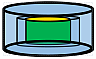
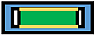

In [15]:
def embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    primary_cylinder = make_vertical_cylinder(roi_num=9, radius=4, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    center_hole = make_vertical_cylinder(roi_num=9, radius=2, length=0.5,
                                         offset_z=-0.2, spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    middle_cylinder = make_vertical_cylinder(roi_num=10, radius=1, length=0.5,
                                             offset_z=-0.2,
                                             spacing=slice_spacing)
    reference = make_vertical_cylinder(roi_num=11, radius=2, length=0.5,
                                         offset_z=-0.2, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, center_hole, middle_cylinder, reference])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


print(find_relationship(embedded_cylinder(), [9, 10]))


Relationship: Surrounds


- The `boundary_match` and `match_neighbour_slices` functions will need to be updated to include the hole boundary tests.
  - For hole boundaries, select the neighboring slice (s) that *DO* have a hole contour.
  - The Secondary slice selection works as usual.

In [16]:

def get_neighbour_slices(boundary_index, slice_index,
                            shift_dir)->pd.DataFrame:
    # Find the boundary neighbours
    # Get the index of the previous slice
    neighbour_slice = slice_index.shift(shift_dir)
    # Select only the slices that are boundary slices of the primary ROI
    neighbour_boundary_slices = neighbour_slice[boundary_index]
    # Drop the neighbour slices that contain a primary contour
    neighbour_boundary_slices.dropna(inplace=True)
    # Reset the index to get the boundary slice number
    neighbour_boundary_slices = neighbour_boundary_slices.reset_index()
    neighbour_boundary_slices.columns = ['Boundary', 'Neighbour']
    return neighbour_boundary_slices

def no_structure_idx(slice_table, roi_num):
    # Create a series containing the slice index for slices that
    # do NOT have a primary contour
    no_contour_idx = slice_table.index.to_series(name='ROI_Index')
    # Select all slices that do not contain a contour for the Primary ROI
    missing_contour = slice_table[roi_num].apply(empty_structure)
    # Remove the slice indexes that have a primary contour
    no_contour_idx[~missing_contour] = np.nan
    return no_contour_idx


In [17]:
def dual_embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    left_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    middle_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, left_hole, right_hole, middle_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


print(find_relationship(dual_embedded_cylinder(), [1, 2]))


Relationship: Surrounds


In [18]:
selected_roi = [1, 2]
roi_a, roi_b = selected_roi
primary, secondary = selected_roi
slice_table = dual_embedded_cylinder()
selected_slices = select_slices(slice_table, selected_roi)
selected_slices

ROI Num,1,2
Slice Index,,
-0.3,<structure_slice.StructureSlice object at 0x00...,NaN
-0.2,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
-0.1,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
0.0,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
0.1,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
0.2,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
0.3,<structure_slice.StructureSlice object at 0x00...,NaN


In [19]:

primary_boundaries = find_boundary_slices(slice_table[roi_a])
primary_boundaries

[-0.3, 0.3]

In [20]:

secondary_boundaries = find_boundary_slices(slice_table[roi_b])
secondary_boundaries

[-0.2, 0.2]

In [21]:
holes = []
for slice in slice_table[roi_a].values:
    if not empty_structure(slice):
        slice_holes = slice.interiors
        for hole in slice_holes:
            holes.append({'position': slice.slice_position, 'contour': hole})

pd.DataFrame(holes)

,position,contour
0,-0.2,"POLYGON ((-3.914 1.414, -4.348 0.765, -4.5 0, ..."
1,-0.2,"POLYGON ((1.735 1.848, 1.086 1.414, 0.652 0.76..."
2,-0.1,"POLYGON ((-3.914 1.414, -4.348 0.765, -4.5 0, ..."
3,-0.1,"POLYGON ((1.735 1.848, 1.086 1.414, 0.652 0.76..."
4,0.0,"POLYGON ((-3.914 1.414, -4.348 0.765, -4.5 0, ..."
5,0.0,"POLYGON ((1.735 1.848, 1.086 1.414, 0.652 0.76..."
6,0.1,"POLYGON ((-3.914 1.414, -4.348 0.765, -4.5 0, ..."
7,0.1,"POLYGON ((1.735 1.848, 1.086 1.414, 0.652 0.76..."
8,0.2,"POLYGON ((-3.914 1.414, -4.348 0.765, -4.5 0, ..."
9,0.2,"POLYGON ((1.735 1.848, 1.086 1.414, 0.652 0.76..."


In [22]:
# Get the slice index for slices that do NOT have a primary contour
no_primary_slice_index = no_structure_idx(slice_table, roi_a)
# Identify the previous and next slice for each boundary slice that do
# not have a primary contour
previous_slice = get_neighbour_slices(primary_boundaries,
                                        no_primary_slice_index, shift_dir=-1)
next_slice = get_neighbour_slices(primary_boundaries,
                                    no_primary_slice_index, shift_dir=1)
# Combine the previous and next slices
neighbouring_slices = pd.concat([previous_slice, next_slice],
                                ignore_index=True)
neighbouring_slices


,Boundary,Neighbour
0,0.3,0.4
1,-0.3,-0.4


In [23]:

plot_ab(slice_table.at[0.2,9].contour, slice_table.at[0.2,10].contour)

KeyError: 9

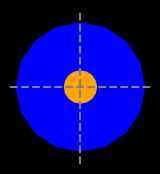

<Axes: >

In [16]:

plot_ab(slice_table.at[0.3,9].contour, slice_table.at[0.2,10].contour)

In [17]:
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = selected_slices.agg(relate_structures,
                                    structures=selected_roi,
                                    axis='columns')
mid_relations.name = 'DE27IM'
mid_relations.apply(bin_format)

Slice Index
-0.3                                           
-0.2     111001001  |  111001001  |  001001111 
-0.1     111001001  |  111001001  |  001001111 
 0.0     111001001  |  111001001  |  001001111 
 0.1     111001001  |  111001001  |  001001111 
 0.2     111001001  |  111001001  |  001001111 
 0.3                                           
Name: DE27IM, dtype: object

In [18]:
# Test the relation between the boundary Primary and the selected Secondary.
matched_slices = boundary_match(slice_table, selected_roi)
bdry_rel = matched_slices.agg(relate_structures, structures=selected_roi,
                                axis='columns')
bdry_rel.name = 'DE27IM'
bdry_rel.apply(bin_format)


Series([], Name: DE27IM, dtype: float64)

In [19]:
# Apply a Primary boundary shift to the relation results.
bdry_rel = bdry_rel.apply(adjust_boundary_relation, shift_type='a')
# If the selected Secondary is also a Secondary boundary, apply a Secondary
#   boundary shift as well.
secondary_boundaries = find_boundary_slices(slice_table[secondary])
bdry_b = [idx for idx in secondary_boundaries
                            if idx in bdry_rel.index]
bdry_rel.loc[bdry_b] = bdry_rel[bdry_b].apply(adjust_boundary_relation,
                                                shift_type='b')
bdry_rel.name = 'DE27IM'
bdry_rel.apply(bin_format)

Series([], Name: DE27IM, dtype: float64)

In [20]:
def overlapping_cylinders():
    slice_spacing = 0.5
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Two overlapping cylinders
    top_cylinder = make_vertical_cylinder(roi_num=7, radius=2, length=0.4, offset_z=-0.3, spacing=slice_spacing)
    bottom_cylinder = make_vertical_cylinder(roi_num=8, radius=2, length=0.4, offset_z=0, spacing=slice_spacing)
   # combine the contours
    slice_data = pd.concat([top_cylinder, bottom_cylinder, body])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


print(find_relationship(overlapping_cylinders(), [7, 8]))


Relationship: Equals


In [21]:
selected_roi = [7, 8]
primary, secondary = selected_roi
slice_table = overlapping_cylinders()
selected_slices = select_slices(slice_table, selected_roi)
selected_slices

ROI Num,7,8
Slice Index,,
-0.3,<structure_slice.StructureSlice object at 0x00...,NaN
-0.2,<structure_slice.StructureSlice object at 0x00...,NaN
-0.1,<structure_slice.StructureSlice object at 0x00...,NaN
0.0,<structure_slice.StructureSlice object at 0x00...,<structure_slice.StructureSlice object at 0x00...
0.1,NaN,<structure_slice.StructureSlice object at 0x00...
0.2,NaN,<structure_slice.StructureSlice object at 0x00...
0.3,NaN,<structure_slice.StructureSlice object at 0x00...


In [22]:
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = selected_slices.agg(relate_structures,
                                    structures=selected_roi,
                                    axis='columns')
mid_relations.name = 'DE27IM'
mid_relations.apply(bin_format)

Slice Index
-0.3                                           
-0.2                                           
-0.1                                           
 0.0     100010001  |  100010001  |  100010001 
 0.1                                           
 0.2                                           
 0.3                                           
Name: DE27IM, dtype: object

In [23]:
# Test the relation between the boundary Primary and the selected Secondary.
matched_slices = boundary_match(slice_table, selected_roi)
bdry_rel = matched_slices.agg(relate_structures, structures=selected_roi,
                                axis='columns')
bdry_rel.name = 'DE27IM'
bdry_rel.apply(bin_format)


IdxB
0.1     100010001  |  100010001  |  100010001 
Name: DE27IM, dtype: object

## Missing secondary boundary test

In [24]:
# Apply a Primary boundary shift to the relation results.
bdry_rel = bdry_rel.apply(adjust_boundary_relation, shift_type='a')
# If the selected Secondary is also a Secondary boundary, apply a Secondary
#   boundary shift as well.
bdry_rel.apply(bin_format)

secondary_boundaries = find_boundary_slices(slice_table[secondary])
print(secondary_boundaries)
bdry_b = [idx for idx in secondary_boundaries
                            if idx in bdry_rel.index]
print(bdry_b)
bdry_rel.loc[bdry_b] = bdry_rel[bdry_b].apply(adjust_boundary_relation,
                                                shift_type='b')
bdry_rel.name = 'DE27IM'
bdry_rel.apply(bin_format)

[0.0, 0.3]
[]


IdxB
0.1     010000001  |  010000001  |  010000001 
Name: DE27IM, dtype: object

In [25]:
# Merge all results and reduce to single relation
mid_relations = pd.concat([mid_relations, bdry_rel], axis='index',
                            ignore_index=True)
relation_binary = merge_rel(mid_relations)
bin_format(relation_binary)

' 110010001  |  110010001  |  110010001 '

# More Tests Needed

  - Single Primary slice with circular contour.
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF Cylinders in one structure with single slice gap at level of the primary slice. 
- **Partition**
  - Concentric cylinders ending on the same slice.
  - Concentric cylinders starting on the same slice
  - Primary: Central Cylinder
    - Single Secondary slice with circular contour on the SUP/INF slice of the Primary cylinder.
  - Single Primary slice with circular contour
    - Secondary: one of:
      - SUP Cylinder ending on the same slice.
      - INF Cylinder ending on the same slice.
- **CONTAINS**
  - Concentric cylinders with interior cylinder ending inside the exterior cylinder by one slice
**OVERLAPS**
  - Concentric cylinders with interior cylinder ending outside the exterior cylinder by one slice
  - Concentric cylinders with interior cylinder consisting of single slice ending inside the exterior cylinder by one slice


  - Primary: Central Cylinder
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF cylinders in one structure with single slice gap at the SUP/INF boundary of the central cylinder.
  - Single Primary slice with circular contour.
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF Cylinders in one structure with single slice gap at level of the primary slice. 
